In [29]:
#Importar librerías:
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.api import Poisson
from scipy import stats
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col

In [ ]:
#pip install statsmodels

### Estimacion de Máxima Verosimilitud

Los [datos](https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/mle/fp.dta?raw=true) provienen del artículo de Daniel Treisman (2016), que concluye que Rusia tiene un número mayor de multimillonarios de lo que predicen factores económicos como el tamaño del mercado y la tasa impositiva.

In [30]:
#Carga de datos 
pd.options.display.max_columns = 10

# Carga de datos.
df = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/mle/fp.dta?raw=true')
df.head()

country  ccode    year    cyear  numbil  ...   topint08     rintr  \
0  United States    2.0  1990.0  21990.0     NaN  ...  39.799999  4.988405   
1  United States    2.0  1991.0  21991.0     NaN  ...  39.799999  4.988405   
2  United States    2.0  1992.0  21992.0     NaN  ...  39.799999  4.988405   
3  United States    2.0  1993.0  21993.0     NaN  ...  39.799999  4.988405   
4  United States    2.0  1994.0  21994.0     NaN  ...  39.799999  4.988405   

   noyrs  roflaw  nrrents  
0   20.0    1.61      NaN  
1   20.0    1.61      NaN  
2   20.0    1.61      NaN  
3   20.0    1.61      NaN  
4   20.0    1.61      NaN  

[5 rows x 36 columns]

Al graficar el histograma de frecuencias se observa que la distribución tiene forma Poisson con cola larga

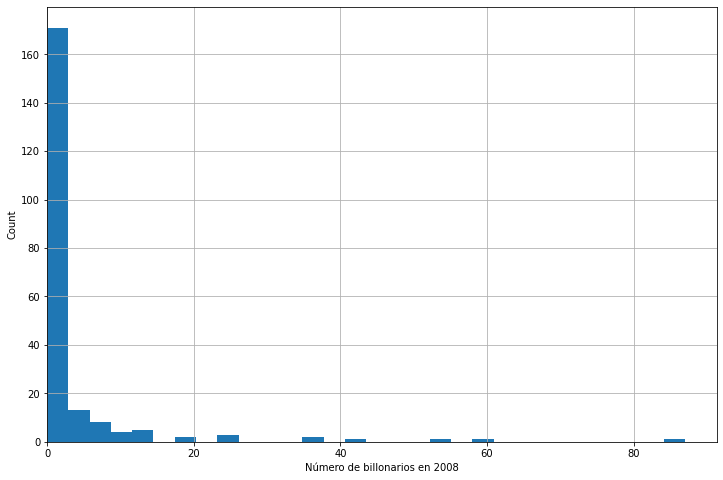

In [35]:
#Histograma de datos:
numbil0_2008 = df[(df['year'] == 2008) & (
    df['country'] != 'United States')].loc[:, 'numbil0']

plt.subplots(figsize=(12, 8))
plt.hist(numbil0_2008, bins=30)
plt.xlim(left=0)
plt.grid()
plt.xlabel('Número de billonarios en 2008')
plt.ylabel('Count')
plt.show()

Códificamos la función de log-verosimilitud asociada a una ditribución Poisson. Crearemos una clase llamada Poisson para que podamos volver a calcular fácilmente los valores de la probabilidad de cada uno de los registros, el gradiente y el hessiano para cada iteración.

In [38]:
class Poisson:

    def __init__(self, y, X, β):
        self.X = X
        self.n, self.k = X.shape
        self.y = y.reshape(self.n,1)
        self.β = β.reshape(self.k,1)

    def μ(self):
        return np.exp(self.X @ self.β)

    def logL(self):
        y = self.y
        μ = self.μ()
        return np.sum(y * np.log(μ) - μ - np.log(factorial(y)))

    def G(self):
        y = self.y
        μ = self.μ()
        return X.T @ (y - μ)

    def H(self):
        X = self.X
        μ = self.μ()
        return -(X.T @ (μ * X))

Construímos la función de Newton-Raphson que permite un modelo como parámetro, a diferencia de la primera función de Newton-Raphson.

In [1]:
def newton_raphson_model(modelo, tolerancia=1e-3, maxiter=1000, display=True):

    i = 0
    error = 100  # Initial error value

    # Print header of output
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"θ":<60}'
        print(header)
        print("-" * len(header))

    while np.any(error > tolerancia) and i < maxiter:
        H, G = modelo.H(), modelo.G()
        β_new = modelo.β - (np.linalg.inv(H) @ G)
        error = β_new - modelo.β
        modelo.β = β_new

        # Print iterations
        if display:
            β_list = [f'{t:.3}' for t in list(modelo.β.flatten())]
            update = f'{i:<13}{modelo.logL():<16.8}{β_list}'
            print(update)

        i += 1

    print(f'Number of iterations: {i}')
    print(f'β_hat = {modelo.β.flatten()}')

    return modelo.β.flatten()

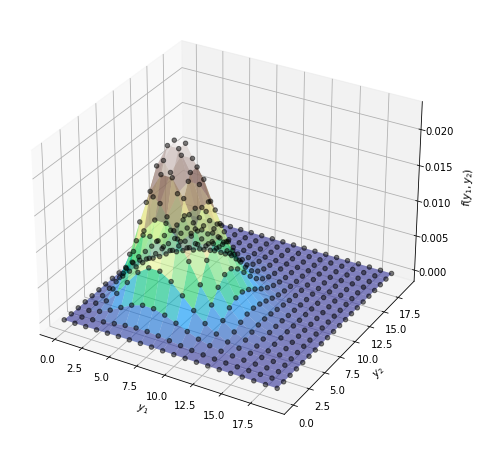

In [25]:
#Primero, necesitamos construir la función de verosimilitud (β), que es similar a una función de densidad de probabilidad conjunta
def plot_joint_poisson(μ=7, y_n=20):
    yi_values = np.arange(0, y_n, 1)

    # Create coordinate points of X and Y
    X, Y = np.meshgrid(yi_values, yi_values)

    # Multiply distributions together
    Z = poisson_pmf(X, μ) * poisson_pmf(Y, μ)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z.T, cmap='terrain', alpha=0.6)
    ax.scatter(X, Y, Z.T, color='black', alpha=0.5, linewidths=1)
    ax.set(xlabel='$y_1$', ylabel='$y_2$')
    ax.set_zlabel('$f(y_1, y_2)$', labelpad=10)
    plt.show()

plot_joint_poisson(μ=7, y_n=20)